In [1]:
import os
import pandas as pd
from pyproj import Transformer
import sys
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.realpath(os.path.abspath(""))))

from utils.parallel import paral

In [2]:
tiles_dir = "/net/scratch/jmoehring/tiles_1024/"
metadata_path = "/net/scratch/jmoehring/metadata_manual_with_resolution.csv"

In [3]:
ecoregion_gdf = gpd.read_file("/net/scratch/jmoehring/wwf_terr_ecos.shp")
metadata_df = pd.read_csv(metadata_path)
metadata_dict = metadata_df.set_index("filename").T.to_dict("dict")

In [4]:
# transform center_lat and center_lon to EPSG:4326 if crs is not EPSG:4326
def transform_coordinates(row):
    if row["crs"] != "EPSG:4326":
        transformer = Transformer.from_crs(row["crs"], "EPSG:4326", always_xy=True)
        return pd.Series(transformer.transform(row["center_lon"], row["center_lat"]))
    else:
        return pd.Series([row["center_lon"], row["center_lat"]])

In [5]:
# find corresponding ecoregion for each image and add the biome value as new column
def find_ecoregion(row):
    point = Point(row["center_lon"], row["center_lat"])
    ecoregions = ecoregion_gdf[ecoregion_gdf.geometry.contains(point)]
    if len(ecoregions) == 1:
        return ecoregions["BIOME"].iloc[0]
    else:
        raise ValueError(f"Point {point} is in {len(ecoregions)} ecoregions")

In [6]:
def process_file(path):
    file, root = path
    file_name = file.split("/")[-1]
    if file_name.endswith(".tif") and not "mask" in file_name:
        # get folder name two above the file
        base_file_folder = root.split("/")[-2]
        base_file_name = f"{base_file_folder}.tif"
        resolution = root.split("/")[-1]
        base_file_meta = metadata_dict[base_file_name]
        # extract x and y from file name with format "x_y.tif"
        x, y = file_name.split(".")[0].split("_")
        # get absolute path of the file
        file_path = os.path.join(root, file_name)
        register_row = {
            "base_file_name": base_file_name,
            "file_path": file_path,
            "global_file_path": file_path.replace(tiles_dir, "/"),
            "resolution": resolution,
            "x": x,
            "y": y,
            "label_quality": base_file_meta["label_quality"],
        }
        return register_row

In [7]:
# add column with EPSG:4326 lat and long of the center of the image. If the image is not in EPSG:4326, the center of the image is calculated in the original projection
metadata_df["center_lat"] = (metadata_df["north"] + metadata_df["south"]) / 2
metadata_df["center_lon"] = (metadata_df["east"] + metadata_df["west"]) / 2

# apply transforma_coordinates to the metadata_df
metadata_df[["center_lon", "center_lat"]] = metadata_df.apply(
    transform_coordinates, axis=1
)
metadata_df["biome"] = metadata_df.apply(find_ecoregion, axis=1)

In [8]:
paths = [(file, root) for root, _, files in os.walk(tiles_dir) for file in files]

In [9]:
register_rows = paral(process_file, [paths], num_cores=20)
register_rows = [row for row in register_rows if row is not None]

process_file: 100%|██████████| 400375/400375 [03:17<00:00, 2025.23jobs/s]


In [10]:
register_df = pd.DataFrame(register_rows)

In [11]:
resolution_bins = np.arange(0, 0.21, 0.02)
register_df["resolution_bin"] = resolution_bins[
    np.digitize(register_df["resolution"].astype(float), resolution_bins) - 1
]

In [12]:
# add boolean column "original" which is true for all tiles with the lowest resolution in the same base_file_name
register_df["original"] = register_df.groupby("base_file_name")["resolution"].transform(
    lambda x: x == x.min()
)

In [13]:
# add biome column to register_df joined on the filename
register_df = register_df.merge(
    right=metadata_df[["filename", "biome"]],
    left_on="base_file_name",
    right_on="filename",
).drop(columns="filename")

<Axes: >

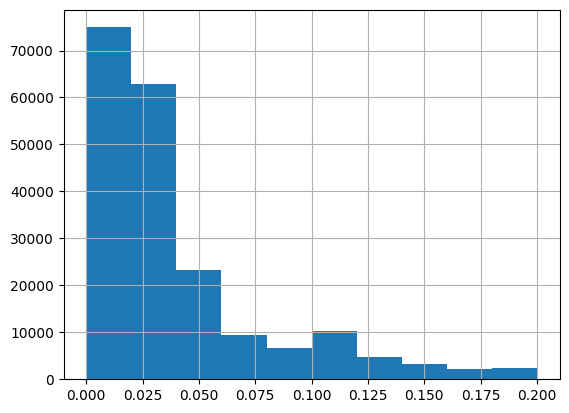

In [14]:
register_df["resolution_bin"].hist()

In [15]:
register_df.to_csv("/net/scratch/jmoehring/tiles_register_1024_biome.csv", index=False)